<a href="https://colab.research.google.com/github/sur-sakthy/computer-vision/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #1
The provided data has a train/validation split of 1000/500 (approx.) images. In this task you are to select any 4 classes from the original ImageNette data as your working dataset (i.e. classification whereby you are predicting one of four possible classes).

Additionally, you need to reorganise the data into appropriate train/validation/test split before you train your network models. The details of the splitting is left to you, but you must fully justify any final split used in your evaluation.

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!cp '/content/drive/MyDrive/EE544 Computer Vision/imagenette2-160.tgz' ./

In [3]:
# remove %%capture command to show output from unzipping
%%capture 
!tar zxvf /content/imagenette2-160.tgz

## Imports

In [4]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, AUC, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

## Constants

In [5]:
PATH_TO_TRAIN_DATA = '/content/imagenette2-160/train'
PATH_TO_VAL_DATA = '/content/imagenette2-160/val'
IMG_WIDTH=64
IMG_HEIGHT=64
NUM_CLASSES=4

In [6]:
all_classes = os.listdir(PATH_TO_TRAIN_DATA)
all_classes

['n03425413',
 '.DS_Store',
 'n02979186',
 'n03000684',
 'n03888257',
 'n03445777',
 'n03394916',
 'n03028079',
 'n02102040',
 'n03417042',
 'n01440764']

In [7]:
all_classes = os.listdir(PATH_TO_VAL_DATA)
all_classes

['n03425413',
 'n02979186',
 'n03000684',
 'n03888257',
 'n03445777',
 'n03394916',
 'n03028079',
 'n02102040',
 'n03417042',
 'n01440764']

## Load dataset

In [8]:
data = []
labels = []

In [9]:
def load_dataset(img_folder): 
    for dir in os.listdir(img_folder):
      if dir == 'n03445777' or dir == 'n03417042' or dir == 'n02979186' or dir == 'n03028079' :
        for file in os.listdir(os.path.join(img_folder, dir)):
            image_path = os.path.join(img_folder, dir, file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64,64))
            input_arr = tf.keras.preprocessing.image.img_to_array(image)
            input_arr = np.array([input_arr])
            image = np.array(image)
            data.append(image)
            labels.append(dir)

In [10]:
load_dataset(PATH_TO_TRAIN_DATA)
load_dataset(PATH_TO_VAL_DATA)

In [11]:
np.unique(labels)

array(['n02979186', 'n03028079', 'n03417042', 'n03445777'], dtype='<U9')

In [12]:
data[0]

array([[[146, 101,  72],
        [151,  98,  64],
        [137,  93,  66],
        ...,
        [255, 208, 183],
        [252, 202, 177],
        [245, 195, 170]],

       [[185, 138, 110],
        [136,  82,  46],
        [104,  63,  41],
        ...,
        [255, 207, 182],
        [252, 202, 177],
        [247, 197, 172]],

       [[135,  88,  58],
        [157,  97,  60],
        [ 24,   0,   0],
        ...,
        [255, 206, 181],
        [253, 203, 178],
        [249, 199, 174]],

       ...,

       [[ 67,   4,   0],
        [ 63,   3,   2],
        [ 56,   0,   5],
        ...,
        [231, 184, 158],
        [222, 175, 149],
        [222, 175, 149]],

       [[107,  38,   5],
        [ 86,  22,   0],
        [ 72,   2,   0],
        ...,
        [228, 181, 155],
        [231, 184, 158],
        [219, 172, 146]],

       [[107,  46,   0],
        [ 98,  43,   4],
        [ 92,  24,   5],
        ...,
        [231, 184, 158],
        [225, 178, 152],
        [207, 160, 134]]

## Shuffle and split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

## Class distribution

In [14]:
df_train = pd.DataFrame(y_train, columns=['label'])
df_train.head()

,label
0,n03028079
1,n02979186
2,n02979186
3,n03028079
4,n03417042


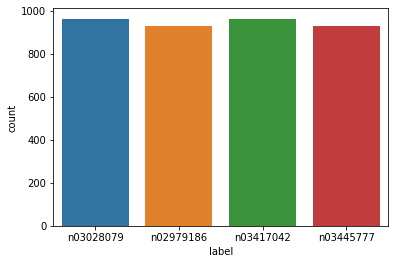

In [15]:
sns.countplot(data=df_train, x='label')
plt.show()

In [16]:
df_test = pd.DataFrame(y_test, columns=['label'])
df_test.head()

,label
0,n03028079
1,n03417042
2,n03028079
3,n03028079
4,n03028079


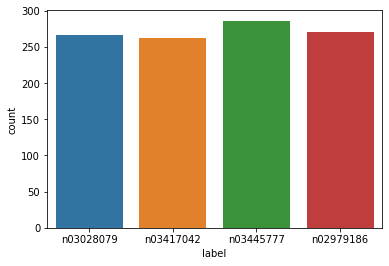

In [17]:
sns.countplot(data=df_test, x='label')
plt.show()

In [18]:
df_val = pd.DataFrame(y_val, columns=['label'])
df_val.head()

,label
0,n03028079
1,n02979186
2,n03445777
3,n03445777
4,n02979186


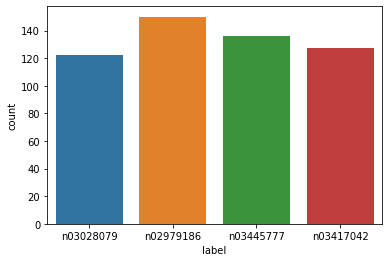

In [19]:
sns.countplot(data=df_val, x='label')
plt.show()

## Encoding

In [20]:
def one_hot_encode(y, num_classes):
  le = LabelEncoder()
  return to_categorical(le.fit_transform(y), num_classes)

In [21]:
y_train[0]

'n03028079'

In [22]:
y_train = one_hot_encode(y_train, NUM_CLASSES)

In [23]:
y_train[0]

array([0., 1., 0., 0.], dtype=float32)

In [24]:
y_test[0]

'n03028079'

In [25]:
y_test = one_hot_encode(y_test, NUM_CLASSES)

In [26]:
y_test[0]

array([0., 1., 0., 0.], dtype=float32)

In [27]:
np.array(y_train).shape

(3780, 4)

In [28]:
y_val[0]

'n03028079'

In [29]:
y_val = one_hot_encode(y_val, NUM_CLASSES)

In [30]:
y_val

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

## Create train, validation and test sets

In [31]:
train_datagen = ImageDataGenerator(        
        rescale=1./255,
        fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
train_ds = train_datagen.flow(
  np.array(X_train), y_train,
  shuffle=True,
  batch_size=128
)

val_ds = train_datagen.flow(
  np.array(X_val), y_val,
  shuffle=True,
  batch_size=128
)

test_ds = test_datagen.flow(
  np.array(X_test), y_test,
  shuffle=False,
  batch_size=128
)

In [33]:
print('Shape of training samples: ', train_ds.x.shape)
print('Shape of validation samples: ', val_ds.x.shape)
print('Shape of test samples: ', test_ds.x.shape)

Shape of training samples:  (3780, 64, 64, 3)
Shape of validation samples:  (535, 64, 64, 3)
Shape of test samples:  (1085, 64, 64, 3)


## Build model

In [34]:
def build_model(batchNorm=False, dropOut=False, l2Reg=False):
  model = Sequential()

  if l2Reg:
    model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer='l2', input_shape=(64,64,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer='l2'))
  else:
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(64,64,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))

  if batchNorm:
    model.add(BatchNormalization())

  if l2Reg:
    model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer='l2'))
    model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer='l2'))
  else:
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))

  if batchNorm:
    model.add(BatchNormalization())

  model.add(Flatten())

  if l2Reg:
    model.add(Dense(512, kernel_regularizer='l2'))
  else:
    model.add(Dense(512))
  
  if dropOut:
    model.add(Dropout(0.25))

  if l2Reg:
    model.add(Dense(NUM_CLASSES, activation='softmax', kernel_regularizer='l2'))
  else:
    model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(
      optimizer=Adam(),
      loss='categorical_crossentropy',
      metrics=[
          CategoricalAccuracy(),
          Precision(), 
          Recall(),
          AUC()
        ]
  )

  return model

In [35]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                    

## Train model

### Initialise callbacks

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/EE544 Computer Vision/task-1-best-weights.hdf5', verbose=1, save_best_only=True, monitor='val_categorical_accuracy')

### Fit the model

In [37]:
history = model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 1.3229 - categorical_accuracy: 0.4098 - precision: 0.5292 - recall: 0.1008 - auc: 0.6684
Epoch 1: val_categorical_accuracy improved from -inf to 0.54766, saving model to /content/drive/MyDrive/EE544 Computer Vision/task-1-best-weights.hdf5
30/30 [==============================] - 94s 3s/step - loss: 1.3229 - categorical_accuracy: 0.4098 - precision: 0.5292 - recall: 0.1008 - auc: 0.6684 - val_loss: 1.0422 - val_categorical_accuracy: 0.5477 - val_precision: 0.6677 - val_recall: 0.4168 - val_auc: 0.8095
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 0.9141 - categorical_accuracy: 0.6368 - precision: 0.7286 - recall: 0.5127 - auc: 0.8564
Epoch 2: val_categorical_accuracy improved from 0.54766 to 0.72710, saving model to /content/drive/MyDrive/EE544 Computer Vision/task-1-best-weights.hdf5
30/30 [==============================] - 85s 3s/step - loss: 0.9141 - categorical_accuracy: 0.6368 - precision: 0.

## Plot results

In [38]:
def plot(train, validation, ylabel, title):
  plt.plot(train, color='red', label='train') 
  plt.plot(validation, color='blue', label='validation') 
  plt.title(title) 
  plt.ylabel(ylabel)
  plt.xlabel('Epoch')
  plt.legend() 
  plt.grid(linestyle='-', linewidth=0.5)

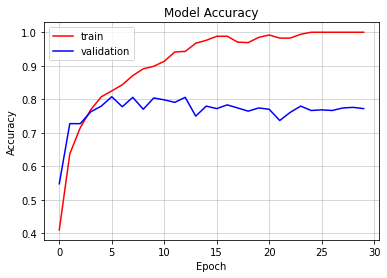

In [39]:
plot(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

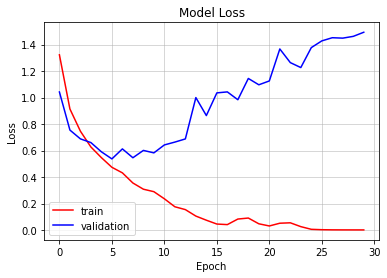

In [40]:
plot(history.history['loss'], history.history['val_loss'], 'Loss', 'Model Loss')

## Evaluate model

In [41]:
eval_results = model.evaluate(test_ds, batch_size=30)

9/9 [==============================] - 7s 806ms/step - loss: 1.6266 - categorical_accuracy: 0.7843 - precision: 0.7865 - recall: 0.7843 - auc: 0.9071


In [42]:
print('Test loss:', eval_results[0])
print('Test categorical_accuracy:', eval_results[1])
print('Test precision:', eval_results[2])
print('Test recall:', eval_results[3])
print('Test auc:', eval_results[4])

Test loss: 1.626563549041748
Test categorical_accuracy: 0.7843317985534668
Test precision: 0.7865064740180969
Test recall: 0.7843317985534668
Test auc: 0.9071344137191772


In [43]:
pred = model.predict(test_ds)

9/9 [==============================] - 4s 473ms/step


In [ ]:
pred

In [45]:
def draw_confusion_matrix(true, pred):
  cm = confusion_matrix(true.argmax(axis=1), pred.argmax(axis=1))
  sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g', cbar=False, cmap="viridis")
  plt.show()

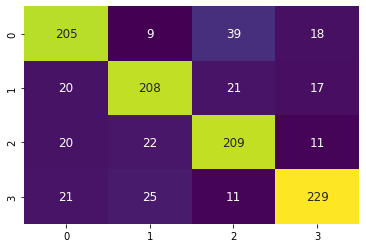

In [46]:
draw_confusion_matrix(y_test, pred)

In [47]:
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       271
           1       0.79      0.78      0.78       266
           2       0.75      0.80      0.77       262
           3       0.83      0.80      0.82       286

    accuracy                           0.78      1085
   macro avg       0.78      0.78      0.78      1085
weighted avg       0.79      0.78      0.78      1085



## Improve the baseline networks performance
1. Batch Normalisation 
2. Dropout 
3. Regularisation

### Batch Normalisation

In [48]:
batchnorm_model = build_model(batchNorm=True)
batchnorm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 64)       

In [ ]:
batchnorm_history = batchnorm_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
30/30 [==============================] - 86s 3s/step - loss: 6.2554 - categorical_accuracy: 0.5868 - precision_1: 0.5905 - recall_1: 0.5852 - auc_1: 0.7674 - val_loss: 1.6190 - val_categorical_accuracy: 0.2561 - val_precision_1: 0.2556 - val_recall_1: 0.1701 - val_auc_1: 0.5585
Epoch 2/30
30/30 [==============================] - 82s 3s/step - loss: 1.9516 - categorical_accuracy: 0.7519 - precision_1: 0.7543 - recall_1: 0.7503 - auc_1: 0.8875 - val_loss: 1.7144 - val_categorical_accuracy: 0.2542 - val_precision_1: 0.2765 - val_recall_1: 0.2393 - val_auc_1: 0.5711
Epoch 3/30
30/30 [==============================] - 82s 3s/step - loss: 0.6970 - categorical_accuracy: 0.8439 - precision_1: 0.8477 - recall_1: 0.8421 - auc_1: 0.9551 - val_loss: 1.9820 - val_categorical_accuracy: 0.2542 - val_precision_1: 0.2596 - val_recall_1: 0.2523 - val_auc_1: 0.5674
Epoch 4/30
30/30 [==============================] - 85s 3s/step - loss: 0.3167 - categorical_accuracy: 0.9143 - precision_1: 0.916

In [ ]:
plot(batchnorm_history.history['categorical_accuracy'], batchnorm_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

In [ ]:
plot(batchnorm_history.history['loss'], batchnorm_history.history['val_loss'], 'Loss', 'Model Loss')

### Dropout

In [ ]:
dropout_model = build_model(dropOut=True)
dropout_model.summary()

In [ ]:
dropout_history = dropout_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

In [ ]:
plot(dropout_history.history['categorical_accuracy'], dropout_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

In [ ]:
plot(dropout_history.history['loss'], dropout_history.history['val_loss'], 'Loss', 'Model Loss')

### L2 Regularisation

In [ ]:
l2reg_model = build_model(l2Reg=True)
l2reg_model.summary()

In [ ]:
l2reg_history = l2reg_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

In [ ]:
plot(l2reg_history.history['categorical_accuracy'], l2reg_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

In [ ]:
plot(l2reg_history.history['loss'], l2reg_history.history['val_loss'], 'Loss', 'Model Loss')